In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1. Functions

## 1.1 Functions for data preprocessing

In [44]:
##========================================================================
## Process consectutive missing data
##========================================================================
def preprocess_data(df, MID, effective_start_time, effective_end_time, pvsize, fillmethod):
    # df = [time, power generation]
    # replace the negative values with zero
    df.loc[df[MID]<0, MID] = 0
    # Step 1. replace outlier (larger than pvsize) with nan
    df_outlier_idx = df[df[MID].astype(float) > 1.2*pvsize]
    df.iloc[df_outlier_idx.index.to_list(), 1] = np.nan
    df.set_index('time', inplace=True)
    # Step 2. fill missing data
    if fillmethod == 'linear':
        df[MID] = df[MID].interpolate()
    elif fillmethod == 'time':
        df[MID] = df[MID].interpolate(method='time')
    elif fillmethod == 'nearest':
        df[MID] = df[MID].interpolate(method='nearest')
    elif (fillmethod == 'ffill') | (fillmethod == 'bfill'): # Replace NaN with preceding values
        df[MID].fillna(method='ffill', inplace=True)
        df[MID].fillna(method='bfill', inplace=True)
    else:
        RecursionError('Please check the fill method')
    df[MID].fillna(0, inplace=True)
    # Step 3. night time should be zero
    df.loc[(df['hour']<effective_start_time)|(df['hour']>effective_end_time), MID] = 0
    df.reset_index(inplace=True)
    return df

In [50]:
# Create a function to apply to each element in the DataFrame
def set_to_true_or_nan(x):
    if pd.isna(x):
        return x
    return x > 0.8

In [51]:
##========================================================================
## clear-sky days
##========================================================================
def clearsky_cal(date_start, date_end):
    # read the clear-sky model generation for different PV sites
    df_site = pd.read_csv('../preprocessed_data/PVsite_daily_20231016.csv')

    df_site_clearsky = df_site.filter(like='EnergyYield.kWh.Daily')
    split_columns = df_site_clearsky.columns.str.split(':').str[1]
    df_site_clearsky.columns = split_columns
    df_site_clearsky.insert(0, 'date', df_site['date'].values)
    df_site_clearsky = df_site_clearsky[(df_site_clearsky['date'] >= date_start) & (df_site_clearsky['date'] <= date_end)]

    # read the expected generation of different PV sites
    df_site_expected = df_site.filter(like='Irrad.kWh.m2.Daily')
    split_columns = df_site_expected.columns.str.split(':').str[1]
    df_site_expected.columns = split_columns
    df_site_expected.insert(0, 'date', df_site['date'].values)
    df_site_expected = df_site_expected[(df_site_expected['date'] >= date_start) & (df_site_expected['date'] <= date_end)]

    # Calculate the cloudiness
    df_cloudiness = df_site_clearsky.copy()
    df_cloudiness.iloc[:, 1:] = df_site_expected.iloc[:, 1:]/df_site_clearsky.iloc[:, 1:]
    df_cloudiness.iloc[:, 1:] = df_cloudiness.iloc[:, 1:].astype(float)
    df_cloudiness.dropna(how='all', axis=1, inplace=True)
    df_cloudiness.iloc[:, 1:].fillna(axis=1, method='ffill', inplace=True)

    df_clearday_sites = df_cloudiness.copy()

    # Apply the function to the entire DataFrame
    df_clearday_sites.iloc[:, 1:] = df_clearday_sites.iloc[:, 1:].applymap(set_to_true_or_nan)
    return df_clearday_sites


## 2 Parameter Settings

In [68]:
fillmethod = 'nearest' # preprocess missing data
if_only_clearsky = True
start_date = '2023-01-01'
end_date = '2023-05-01'
timeslots_daily = 21*12
# 5am - 20 pm
effective_start_time = 5
effective_end_time = 20
effective_timeslots_daily = (effective_end_time-effective_start_time + 1)*4
# threshold values
threshold_low_cloudiness = 0.9
threshold_for_effective_power = 0.2 # normalised one with PV size
threshold_for_effective_time = 0.5 # at least half data is effective, then it will be considered for fault detection

# MID
MID = 'MNTR|7053139'

effective_timeslots_daily

64

## 3 Read Data

In [ ]:
# read meta table
df_att = pd.read_csv('../input_data/MNTR_ddb_20230630.csv', header=0)
att_list = ['latitude', 'longitude', 'tilt', 'azimuth', 'loss', 'pvSizeWatt']
df_att['latitude'] = [x[1:] for x in df_att['latitude']]

site_id = df_att.loc[df_att['source']==MID, 'siteId'].values[0]
df_att.head()

### 3.1. Data preprocessing for 5-min data

In [11]:
# read raw data with 5-min time resolution
file_5min_path = '../preprocessed_data/5min_rawdata_20230630.csv'
df_5min = pd.read_csv(file_5min_path, header=0, index_col=0)
df_5min = df_5min[(df_5min['time'] >= start_date) & (df_5min['time'] < end_date)]

df_MID = df_5min[['time', MID]].copy()
df_MID.index = range(len(df_MID.index))
df_MID['time'] = pd.to_datetime(df_MID['time'])
df_MID['hour'] = df_MID['time'].dt.hour
df_MID['date'] = df_MID['time'].dt.date
df_MID['date'] = df_MID['date'].astype(str)

df_MID

time  MNTR|7053139  hour        date
0     2023-01-01 00:00:00+00:00           NaN     0  2023-01-01
1     2023-01-01 00:05:00+00:00           NaN     0  2023-01-01
2     2023-01-01 00:10:00+00:00           NaN     0  2023-01-01
3     2023-01-01 00:15:00+00:00           NaN     0  2023-01-01
4     2023-01-01 00:20:00+00:00           NaN     0  2023-01-01
...                         ...           ...   ...         ...
34555 2023-04-30 23:35:00+00:00           NaN    23  2023-04-30
34556 2023-04-30 23:40:00+00:00           NaN    23  2023-04-30
34557 2023-04-30 23:45:00+00:00           NaN    23  2023-04-30
34558 2023-04-30 23:50:00+00:00           NaN    23  2023-04-30
34559 2023-04-30 23:55:00+00:00           NaN    23  2023-04-30

[34560 rows x 4 columns]

<Axes: xlabel='time'>

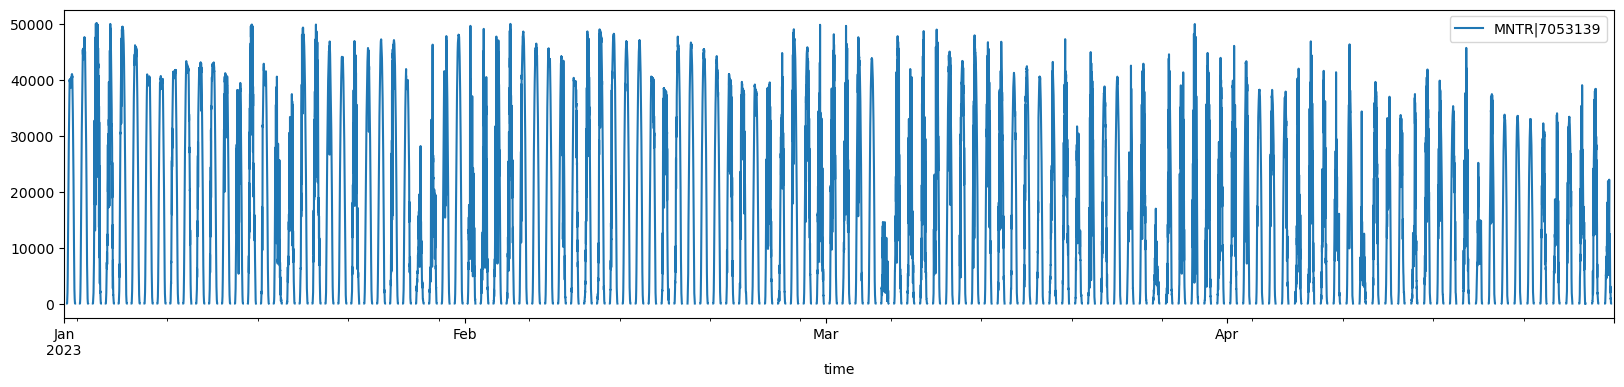

In [9]:

# df_5min.set_index('time').iloc[:, 0:10].plot(figsize=(24,3))
df_MID.set_index('time').plot(figsize=(20, 4))


In [45]:
# ==================  preprocessing missing data of pv systems with 5 minutes resolution ================
df_preprocessed = df_MID.copy()
pvsize = df_att.loc[df_att['source']==MID, 'pvSizeWatt'].values[0]

df_preprocessed = preprocess_data(df=df_preprocessed, MID=MID, effective_start_time=effective_start_time, effective_end_time=effective_end_time, pvsize=pvsize, fillmethod=fillmethod)
df_preprocessed

time  MNTR|7053139  hour        date
0     2023-01-01 00:00:00+00:00           0.0     0  2023-01-01
1     2023-01-01 00:05:00+00:00           0.0     0  2023-01-01
2     2023-01-01 00:10:00+00:00           0.0     0  2023-01-01
3     2023-01-01 00:15:00+00:00           0.0     0  2023-01-01
4     2023-01-01 00:20:00+00:00           0.0     0  2023-01-01
...                         ...           ...   ...         ...
34555 2023-04-30 23:35:00+00:00           0.0    23  2023-04-30
34556 2023-04-30 23:40:00+00:00           0.0    23  2023-04-30
34557 2023-04-30 23:45:00+00:00           0.0    23  2023-04-30
34558 2023-04-30 23:50:00+00:00           0.0    23  2023-04-30
34559 2023-04-30 23:55:00+00:00           0.0    23  2023-04-30

[34560 rows x 4 columns]

<Axes: xlabel='time'>

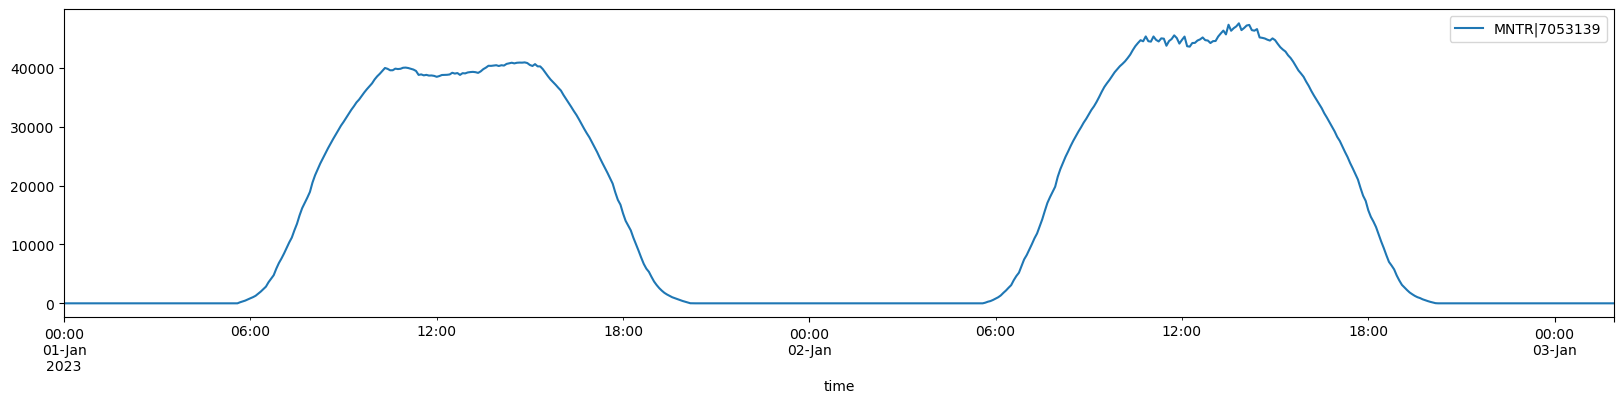

In [48]:
df_preprocessed[['time', MID]].set_index('time').iloc[0:600, :].plot(figsize=(20, 4))

### 3.2. Normalised Data

In [49]:
# normalise each monitor with the PV size
df_normalised = df_preprocessed.copy()
df_normalised[MID] = df_normalised[MID]/pvsize
df_normalised

time  MNTR|7053139  hour        date
0     2023-01-01 00:00:00+00:00           0.0     0  2023-01-01
1     2023-01-01 00:05:00+00:00           0.0     0  2023-01-01
2     2023-01-01 00:10:00+00:00           0.0     0  2023-01-01
3     2023-01-01 00:15:00+00:00           0.0     0  2023-01-01
4     2023-01-01 00:20:00+00:00           0.0     0  2023-01-01
...                         ...           ...   ...         ...
34555 2023-04-30 23:35:00+00:00           0.0    23  2023-04-30
34556 2023-04-30 23:40:00+00:00           0.0    23  2023-04-30
34557 2023-04-30 23:45:00+00:00           0.0    23  2023-04-30
34558 2023-04-30 23:50:00+00:00           0.0    23  2023-04-30
34559 2023-04-30 23:55:00+00:00           0.0    23  2023-04-30

[34560 rows x 4 columns]

### 3.3. Find Clear-Sky days (monitors)

In [56]:
# calculate clear-sky days based on the 
df_clearday_all = clearsky_cal(date_start=start_date, date_end=end_date)
df_clearday_all.head()

date SITE|4dddc226-3464-4c95-aded-875e490a2f02  \
1461  2023-01-01                                     False   
1462  2023-01-02                                      True   
1463  2023-01-03                                      True   
1464  2023-01-04                                     False   
1465  2023-01-05                                     False   

     SITE|c9fcf61f-c1a9-48d8-b2bb-c843dbd69119  \
1461                                      True   
1462                                      True   
1463                                      True   
1464                                     False   
1465                                     False   

     SITE|166b83a9-ad51-4ad2-b853-fdb1aa936f6d  \
1461                                       NaN   
1462                                       NaN   
1463                                       NaN   
1464                                       NaN   
1465                                       NaN   

     SITE|11fde49c-5cd0-429c-8013-97c9a1c1462d  \
1461                                       NaN   
1462                                       NaN   
1463                                       NaN   
1464                                       NaN   
1465                                       NaN   

      SITE|20200be5-9a36-4b8b-b869-4459631ddaf8  \
1461                                       True   
1462                                       True   
1463                                       True   
1464                                       True   
1465                                      False   

     SITE|60cf5b3f-293b-4336-b59f-4fc00fee17ed  \
1461                                       NaN   
1462                                       NaN   
1463                                       NaN   
1464                                       NaN   
1465                                       NaN   

     SITE|c5e8ad5f-9a60-417b-8439-fb3771b62cf0  \
1461                                     False   
1462                                     False   
1463                                     False   
1464                                      True   
1465                                      True   

     SITE|e8368cd8-a32e-4dc6-be01-5d8f4effa6d7  \
1461                                       NaN   
1462                                       NaN   
1463                                       NaN   
1464                                       NaN   
1465                                       NaN   

     SITE|cbba03e8-d924-48a4-a177-d4774f63a991  ...  \
1461                                       NaN  ...   
1462                                       NaN  ...   
1463                                       NaN  ...   
1464                                       NaN  ...   
1465                                       NaN  ...   

     SITE|e4bac0c8-6cce-44ad-b5c3-5a0500be4008  \
1461                                     False   
1462                                      True   
1463                                      True   
1464                                     False   
1465                                     False   

      SITE|75493355-27b1-4676-91b8-dc598d46813b  \
1461                                        NaN   
1462                                        NaN   
1463                                        NaN   
1464                                        NaN   
1465                                        NaN   

      SITE|bca93ed0-dcc7-4262-9bb0-320f25b0d93e  \
1461                                        NaN   
1462                                        NaN   
1463                                        NaN   
1464                                        NaN   
1465                                        NaN   

      SITE|1b3255ea-c7ee-41c3-bfa1-b8748787de0c  \
1461                                       True   
1462                                       True   
1463                                       True   
1464                                      False   
1465                     

In [58]:
# find clear-sky days for the target PV system
clearsky_date_list = df_clearday_all.loc[df_clearday_all[site_id]==True, 'date'].values
clearsky_date_list

array(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-05',
       '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09',
       '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13',
       '2023-01-14', '2023-01-15', '2023-01-16', '2023-01-19',
       '2023-01-20', '2023-01-21', '2023-01-22', '2023-01-24',
       '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-30',
       '2023-01-31', '2023-02-03', '2023-02-04', '2023-02-05',
       '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09',
       '2023-02-10', '2023-02-11', '2023-02-12', '2023-02-13',
       '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17',
       '2023-02-18', '2023-02-19', '2023-02-20', '2023-02-21',
       '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-26',
       '2023-02-27', '2023-03-01', '2023-03-03', '2023-03-04',
       '2023-03-10', '2023-03-11', '2023-03-12', '2023-03-13',
       '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-19',
       '2023-03-22', '2023-03-23', '2023-03-25', '2023-

In [69]:
date_list = df_normalised['date'].unique()
df_timeslots = pd.DataFrame(index=range(timeslots_daily), columns=['time'])
df_timeslots['time'] = df_normalised.loc[df_normalised['date']==date_list[0], 'time']

df_timeslots['hour'] = df_timeslots['time'].dt.hour
df_timeslots['min'] = df_timeslots['time'].dt.minute
df_timeslots.loc[df_timeslots['min']==0, 'min'] = '00'
df_timeslots['hour_min'] = df_timeslots['hour'].astype(str) + ':' + df_timeslots['min'].astype(str)
df_timeslots
df_effective_timeslots = df_timeslots[(df_timeslots['hour']>=effective_start_time)&(df_timeslots['hour']<=effective_end_time)]
df_effective_timeslots.index=range(len(df_effective_timeslots))
df_effective_timeslots

time  hour min hour_min
0   2023-01-01 05:00:00+00:00     5  00     5:00
1   2023-01-01 05:05:00+00:00     5   5      5:5
2   2023-01-01 05:10:00+00:00     5  10     5:10
3   2023-01-01 05:15:00+00:00     5  15     5:15
4   2023-01-01 05:20:00+00:00     5  20     5:20
..                        ...   ...  ..      ...
187 2023-01-01 20:35:00+00:00    20  35    20:35
188 2023-01-01 20:40:00+00:00    20  40    20:40
189 2023-01-01 20:45:00+00:00    20  45    20:45
190 2023-01-01 20:50:00+00:00    20  50    20:50
191 2023-01-01 20:55:00+00:00    20  55    20:55

[192 rows x 4 columns]

### 3.4. Transfer the Data Format for Clustering

In [70]:
##========================================================================
## clear-sky days
##========================================================================
df_raw = pd.DataFrame(index=np.arange(len(clearsky_date_list)), columns=['date'] + df_effective_timeslots['hour_min'].values.tolist())
df_normalised_timeseries = pd.DataFrame(index=np.arange(len(clearsky_date_list)), columns=['date'] + df_effective_timeslots['hour_min'].values.tolist())
clearsky_index = 0
for j, date_id in enumerate(clearsky_date_list):
    df_date_normalise = df_normalised.loc[df_normalised['date']==date_id, ['time', MID]]
    df_date_normalise['hour'] = df_date_normalise['time'].dt.hour
    df_date_normalise = df_date_normalise[(df_date_normalise['hour']>=effective_start_time) & (df_date_normalise['hour']<=effective_end_time)]
    normalise_value = df_date_normalise[MID].values

    df_single_raw = df_preprocessed.loc[df_normalised['date']==date_id, ['time', MID]]
    df_single_raw['hour'] = df_single_raw['time'].dt.hour
    df_single_raw = df_single_raw[(df_single_raw['hour']>=effective_start_time) & (df_single_raw['hour']<=effective_end_time)]
    raw_value = df_single_raw[MID].values

    df_normalised_timeseries.iloc[j, 0] = date_id
    df_normalised_timeseries.iloc[j, 1:] = np.array(normalise_value)

    df_raw.iloc[j, 0] = date_id
    df_raw.iloc[j, 1:] = np.array(raw_value)

df_normalised_timeseries


date 5:00  5:5 5:10 5:15 5:20 5:25 5:30 5:35      5:40  ...  \
0   2023-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.004454  ...   
1   2023-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.002778  ...   
2   2023-01-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0  ...   
3   2023-01-05  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.001001  ...   
4   2023-01-06  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000626  ...   
..         ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...   
75  2023-04-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0  ...   
76  2023-04-23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0  ...   
77  2023-04-24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0  ...   
78  2023-04-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0  ...   
79  2023-04-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0  ...   

       20:10 20:15 20:20 20:25 20:30 20:35 20:40 20:45 20:50 20:55  
0    0.00035   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.000626   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.001126   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.001001   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
..       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
75       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
76       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
77       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
78       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
79       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[80 rows x 193 columns]

In [71]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [72]:
def kmeans_clustering(df, cluster_num, metric_name):
    # Scale the data
    # X = df_preprocessed.iloc[:, 1].values.reshape(-1, 1)
    X = df.iloc[:, 1:]
    scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
    scaled_data = scaler.fit_transform(X)

    # Apply k-means clustering
    kmeans_ = TimeSeriesKMeans(n_clusters=cluster_num, metric=metric_name)
    kmeans_.fit(scaled_data)

    # Get the cluster labels
    cluster_labels = kmeans_.predict(scaled_data)

    return cluster_labels
    

In [117]:
def kmeans_results_plot(df, cluster_labels, cluster_num):
    df_plot = df.copy()
    df_plot['Fault'] = cluster_labels
    for nc in range(cluster_num):
        df_nc = df_plot[df_plot['Fault']==nc]
        fig, axes = plt.subplots(nrows=1, figsize=(16, 5))
        for pvid_time in df_nc['date'].values:
            df_plot_date = df_nc[df_nc['date']==pvid_time]
            axes.plot(df_plot_date.columns.to_list()[1:-1], df_plot_date.values[0][1:-1].astype(float), marker='o')
            axes.grid(axis='y')
        axes.set_xticks(axes.get_xticks()[::5])
        axes.legend()

## 4 Time-series Raw Features for the Clustering

### 4.1. Binary Kmeans & DTW

In [74]:
cluster_labels_binary_dtw = kmeans_clustering(df=df_normalised_timeseries, cluster_num=2, metric_name='dtw')
cluster_labels_binary_dtw

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


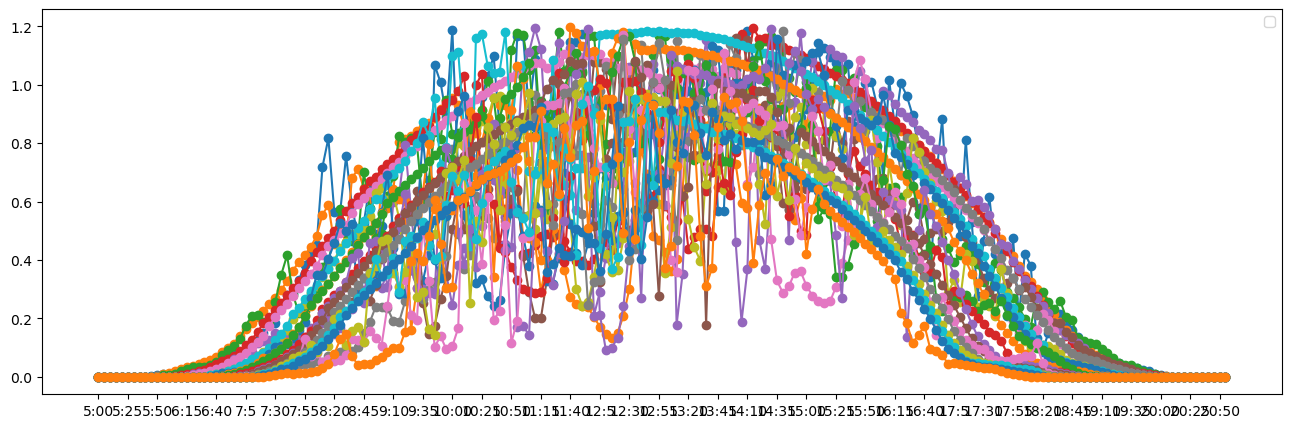

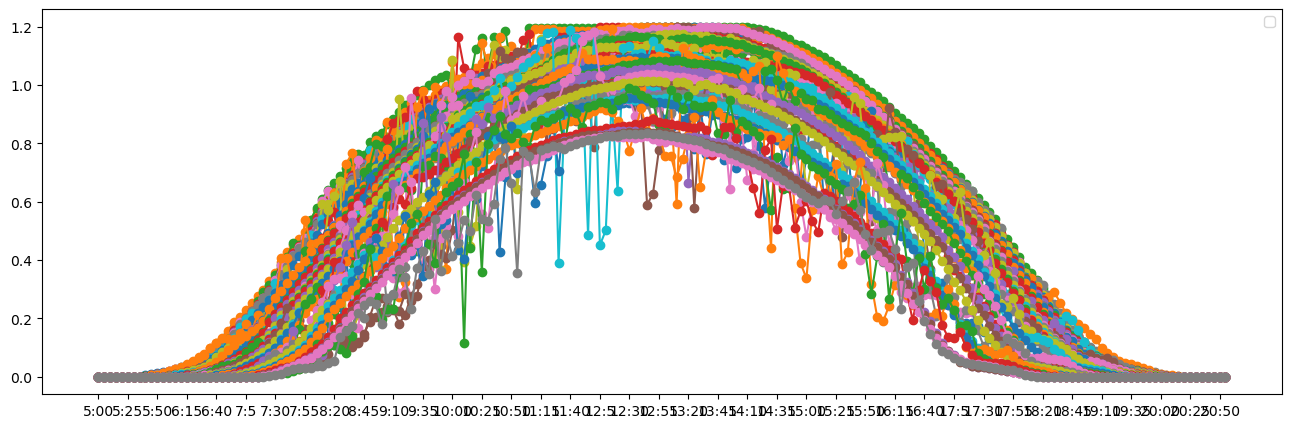

In [118]:
kmeans_results_plot(df=df_normalised_timeseries, cluster_labels=cluster_labels_binary_dtw, cluster_num=2)

### 4.2. Kmeans with multiple clusters

In [89]:
# cluster_labels_multi_dtw = kmeans_clustering(df=df_normalised_timeseries, cluster_num=10, metric_name='dtw')
# kmeans_results_plot(df=df_normalised_timeseries, cluster_labels=cluster_labels_multi_dtw, cluster_num=10)


# 5 Find best cluster number

# 5.1 Elbow Method: Look for the "elbow point" on the plot

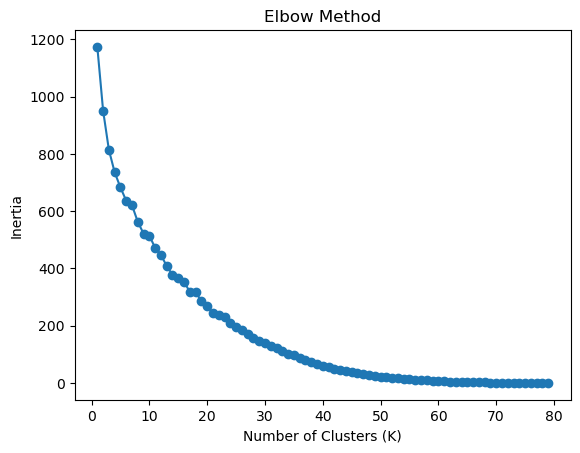

In [85]:
from sklearn.cluster import KMeans

X = df_normalised_timeseries.iloc[:, 1:]
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
scaled_data = scaler.fit_transform(X)
data_2d = scaled_data.reshape(scaled_data.shape[0], -1)
inertias = []
K_range = range(1, 80)  # Choose an appropriate range
for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_2d)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


## 5.2 Silhouette Score: Choose the K that gives the highest Silhouette Score.

In [88]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define a range of cluster numbers to test
K_range = range(2, 11)  # Test from 2 clusters to 10 clusters

silhouette_scores = []

# Iterate through different numbers of clusters
for K in K_range:
    kmeans = KMeans(n_clusters=K)
    labels = kmeans.fit_predict(data_2d)
    score = silhouette_score(data_2d, labels)
    silhouette_scores.append(score)

# Find the best number of clusters based on the highest Silhouette Score
best_K = K_range[silhouette_scores.index(max(silhouette_scores))]
best_K


8

## 5.3 Clustering with the best cluster number

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

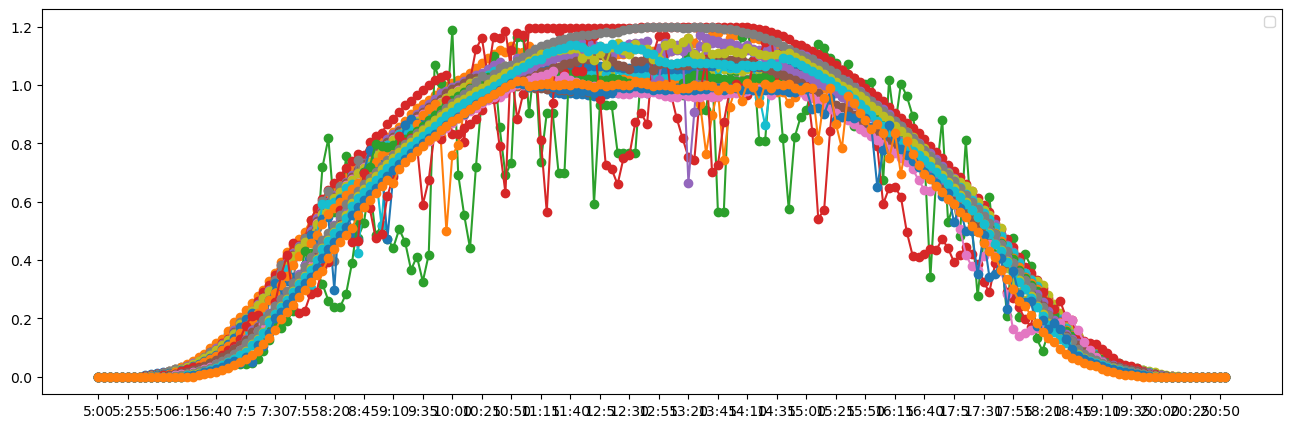

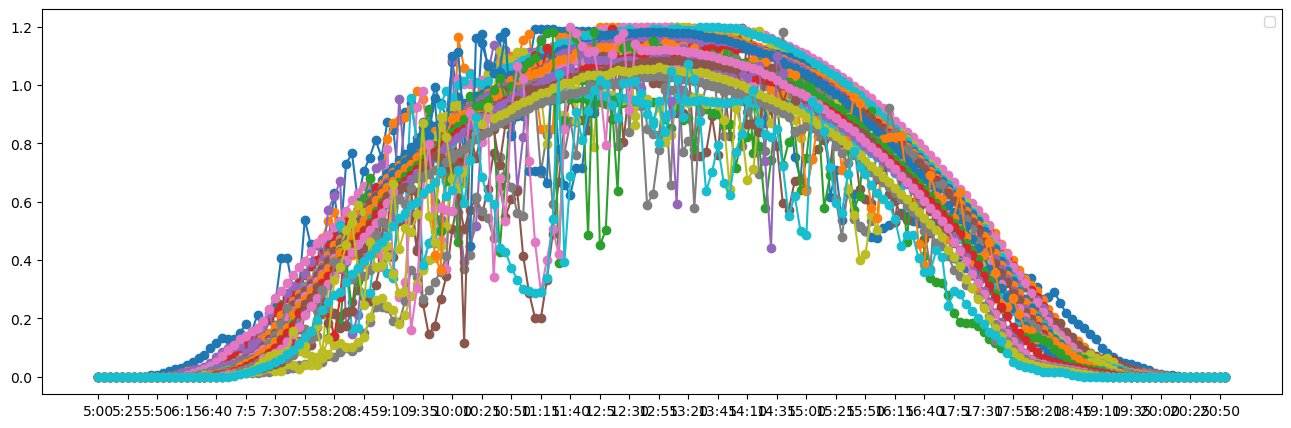

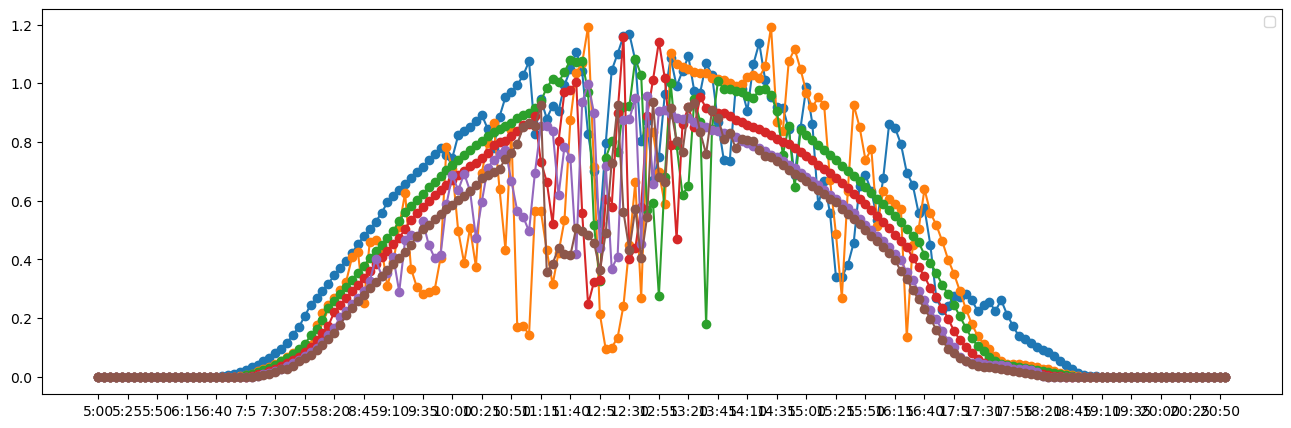

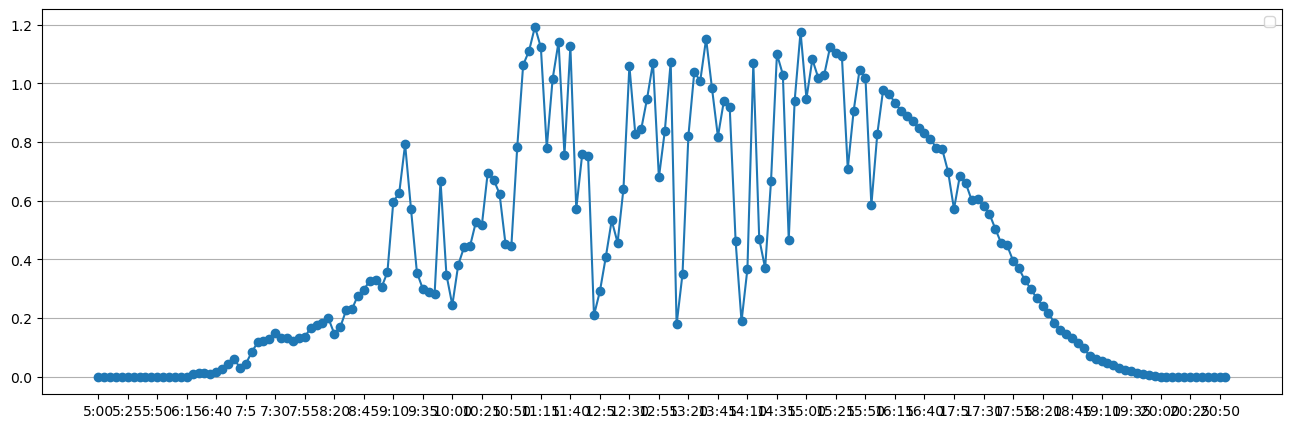

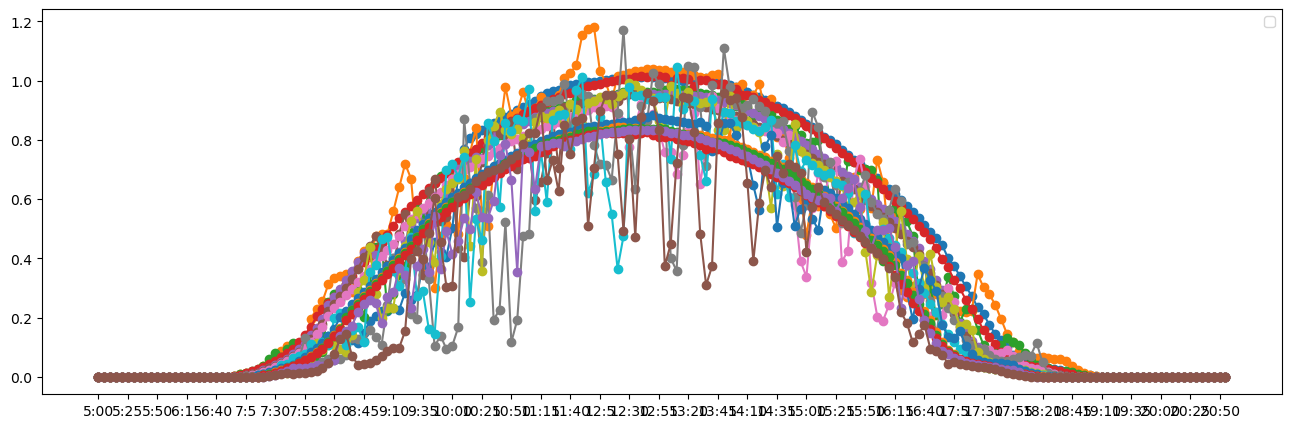

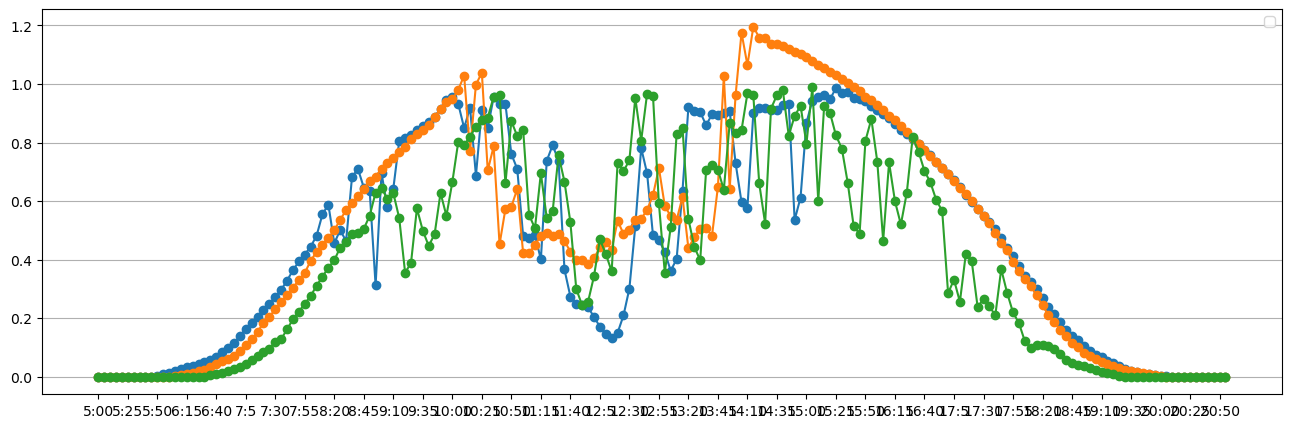

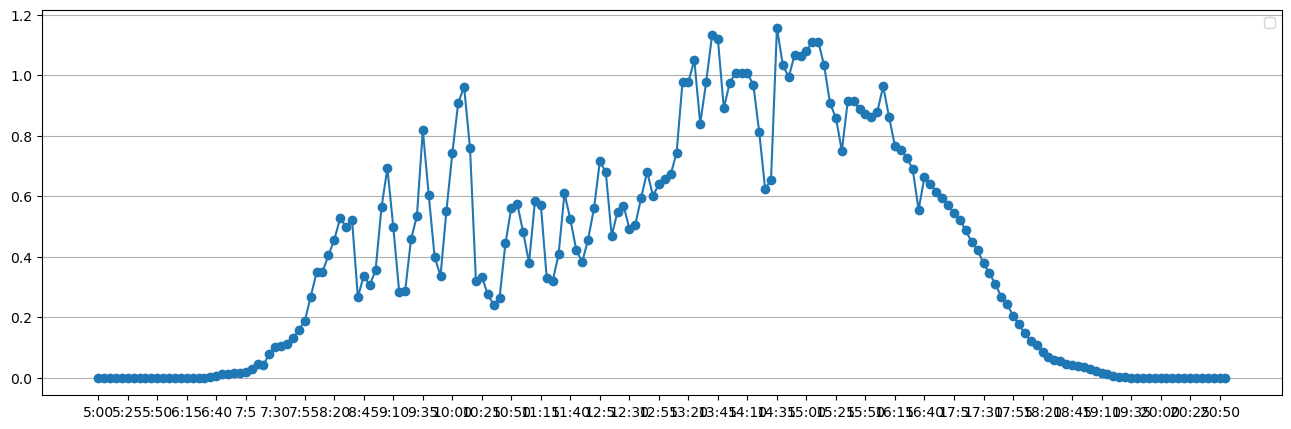

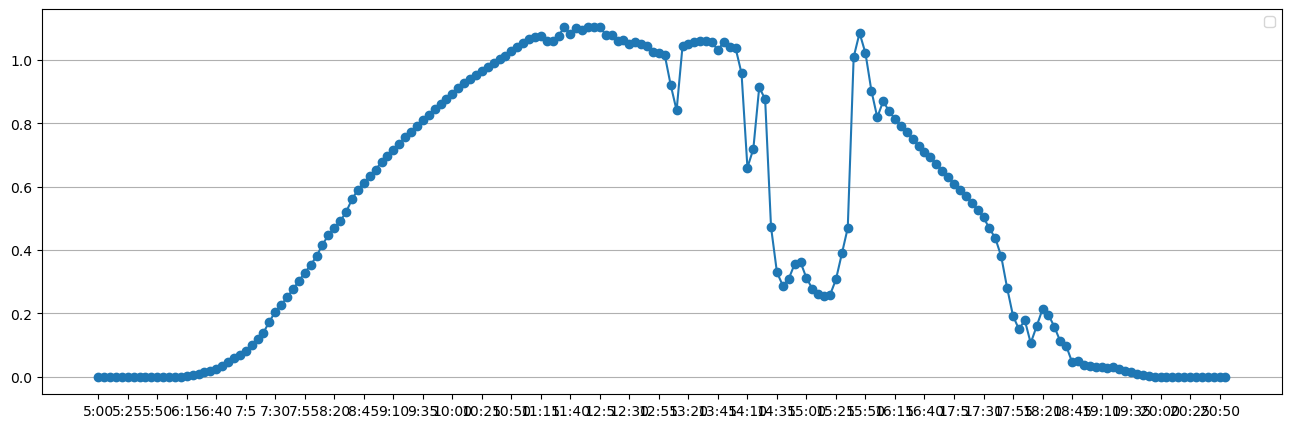

In [119]:
kmeans = KMeans(n_clusters=best_K)
bestk_labels = kmeans.fit_predict(data_2d)
kmeans_results_plot(df=df_normalised_timeseries, cluster_labels=bestk_labels, cluster_num=best_K)

# 6 Clustering with decomposition

## 6.1 Seasonal and Trend decomposition using Loess (STL)

In [91]:
from statsmodels.tsa.seasonal import STL

In [92]:
df_raw_decom = df_normalised.copy()
df_raw_decom['hour'] = df_raw_decom['time'].dt.hour
df_raw_decom = df_raw_decom[(df_raw_decom['hour']>=effective_start_time) & (df_raw_decom['hour']<=effective_end_time)]
df_raw_decom.set_index('time', inplace=True)
df_raw_decom.iloc[0:64, :]

MNTR|7053139  hour        date
time                                                     
2023-01-01 05:00:00+00:00      0.000000     5  2023-01-01
2023-01-01 05:05:00+00:00      0.000000     5  2023-01-01
2023-01-01 05:10:00+00:00      0.000000     5  2023-01-01
2023-01-01 05:15:00+00:00      0.000000     5  2023-01-01
2023-01-01 05:20:00+00:00      0.000000     5  2023-01-01
...                                 ...   ...         ...
2023-01-01 09:55:00+00:00      0.935385     9  2023-01-01
2023-01-01 10:00:00+00:00      0.952202    10  2023-01-01
2023-01-01 10:05:00+00:00      0.965541    10  2023-01-01
2023-01-01 10:10:00+00:00      0.976301    10  2023-01-01
2023-01-01 10:15:00+00:00      0.988313    10  2023-01-01

[64 rows x 3 columns]

In [93]:
def stl_plot(df, trend, seasonal, residual):
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='best')
    plt.title('Original Time Series')

    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()


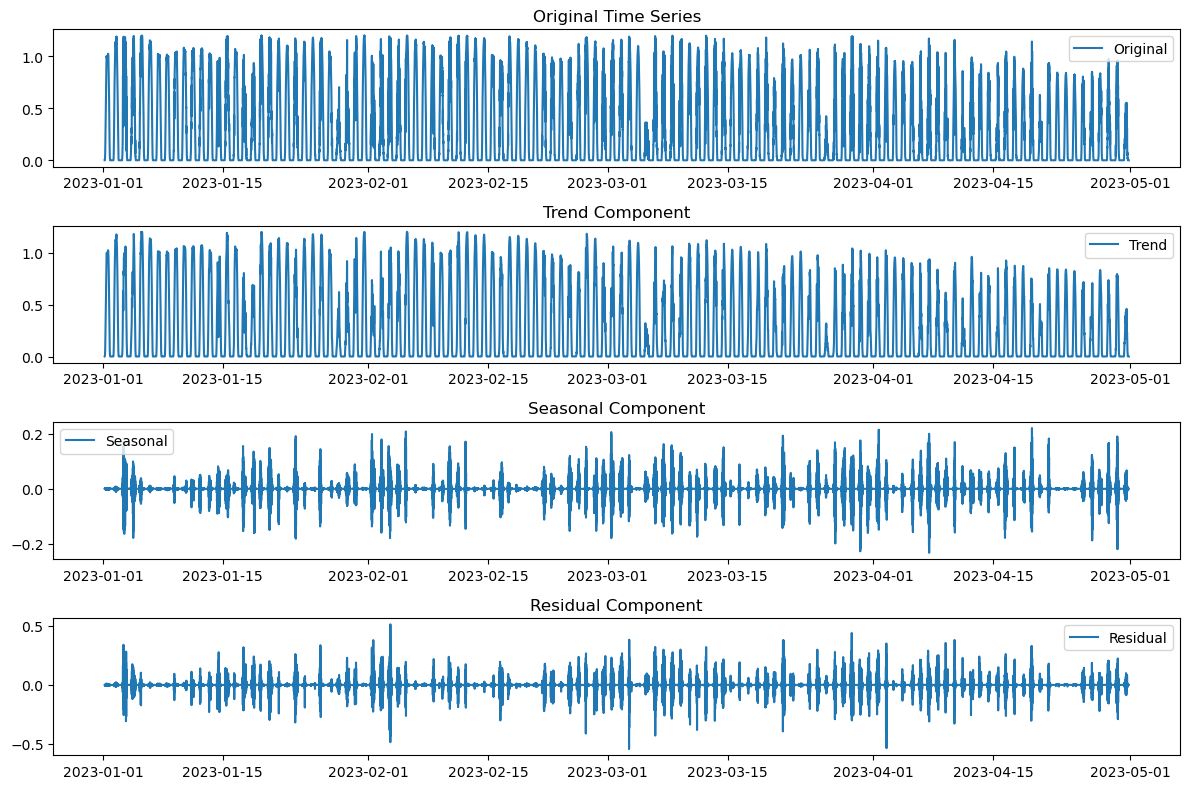

MNTR|7053139  hour        date  trend:MNTR|7053139  \
time                                                                            
2023-01-01 05:00:00+00:00           0.0     5  2023-01-01            0.000582   
2023-01-01 05:05:00+00:00           0.0     5  2023-01-01            0.000659   
2023-01-01 05:10:00+00:00           0.0     5  2023-01-01            0.000758   
2023-01-01 05:15:00+00:00           0.0     5  2023-01-01            0.000896   
2023-01-01 05:20:00+00:00           0.0     5  2023-01-01            0.001108   
...                                 ...   ...         ...                 ...   
2023-04-30 20:35:00+00:00           0.0    20  2023-04-30           -0.000003   
2023-04-30 20:40:00+00:00           0.0    20  2023-04-30           -0.000004   
2023-04-30 20:45:00+00:00           0.0    20  2023-04-30           -0.000004   
2023-04-30 20:50:00+00:00           0.0    20  2023-04-30           -0.000005   
2023-04-30 20:55:00+00:00           0.0    20  2023-04-30           -0.000005   

                           seasonal:MNTR|7053139  residual:MNTR|7053139  
time                                                                     
2023-01-01 05:00:00+00:00           9.781044e-05              -0.000680  
2023-01-01 05:05:00+00:00          -8.168268e-07              -0.000658  
2023-01-01 05:10:00+00:00          -1.369054e-04              -0.000622  
2023-01-01 05:15:00+00:00          -5.178656e-04              -0.000378  
2023-01-01 05:20:00+00:00          -5.244882e-05              -0.001055  
...                                          ...                    ...  
2023-04-30 20:35:00+00:00          -1.189189e-05               0.000015  
2023-04-30 20:40:00+00:00          -3.020247e-05               0.000034  
2023-04-30 20:45:00+00:00          -5.600988e-06               0.000010  
2023-04-30 20:50:00+00:00           1.987785e-05              -0.000015  
2023-04-30 20:55:00+00:00           3.537349e-05              -0.000031  

[23040 rows x 6 columns]

In [94]:
# # =============================================
# = decomposition of each monitor at each day 
# # =============================================

df_stl = df_raw_decom.copy()

stl = STL(df_raw_decom[MID], period=6)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

df_stl['trend:' + MID] = trend.values
df_stl['seasonal:' + MID] = seasonal.values
df_stl['residual:' + MID] = residual.values

stl_plot(df=df_stl[MID], trend=trend, seasonal=seasonal, residual=residual)
df_stl

In [95]:
efftime_list = df_effective_timeslots['hour_min'].values.tolist()

In [96]:
# # =============================================
# = create data for clustering
# = 1. select clear-sky days
# = 2. combine different features
# # =============================================

def create_data_forlearning(df, fea_num, filter_name):
    if fea_num == 1:
        df_norm = pd.DataFrame(index=np.arange(len(clearsky_date_list)), columns=['date'] + ['trend_' + str(element) for element in efftime_list])
    else:
        if filter_name == 'stl':
            df_norm = pd.DataFrame(index=np.arange(len(clearsky_date_list)), 
                                   columns=['date'] + ['trend_' + str(element) for element in efftime_list] +
                                   ['seasonal_' + str(element) for element in efftime_list] + 
                                   ['residual_' + str(element) for element in efftime_list])
        else:
            df_norm = pd.DataFrame(index=np.arange(len(clearsky_date_list)), 
                                   columns=['date'] + ['trend_' + str(element) for element in efftime_list] +
                                   ['cycle_' + str(element) for element in efftime_list])
    
    for j, date_id in enumerate(clearsky_date_list):
        df_monitor_date = df[df['date']==date_id]
        # df_monitor_date.drop(['original:{}'.format(pvid), 'date'], axis=1, inplace=True)
        if fea_num == 1:
            colums_value_list = df_monitor_date['trend:{}'.format(MID)].values
        else:
            colums_value_list = pd.concat([df_monitor_date[col] for col in df_monitor_date.columns.to_list()[3:]], ignore_index=True).values

        df_norm.iloc[j, 0] = date_id
        df_norm.iloc[j, 1:] = np.array(colums_value_list)
    return df_norm

In [97]:
df_normalised_stl = create_data_forlearning(df=df_stl, fea_num=3, filter_name='stl')
df_normalised_stl

date trend_5:00 trend_5:5 trend_5:10 trend_5:15 trend_5:20  \
0   2023-01-01   0.000582  0.000659   0.000758   0.000896   0.001108   
1   2023-01-02  -0.000093 -0.000111  -0.000092  -0.000017   0.000204   
2   2023-01-03  -0.000056 -0.000077  -0.000066  -0.000025   0.000044   
3   2023-01-05  -0.000098  -0.00008  -0.000013   0.000055   0.000153   
4   2023-01-06  -0.000075 -0.000108  -0.000114  -0.000072   0.000061   
..         ...        ...       ...        ...        ...        ...   
75  2023-04-22   0.000001  0.000001   0.000001        0.0  -0.000001   
76  2023-04-23   0.000001  0.000001   0.000001        0.0  -0.000001   
77  2023-04-24   0.000001  0.000001        0.0        0.0  -0.000001   
78  2023-04-27   0.000001  0.000001   0.000001   0.000001        0.0   
79  2023-04-29   0.000001  0.000001        0.0       -0.0  -0.000001   

   trend_5:25 trend_5:30 trend_5:35 trend_5:40  ... residual_20:10  \
0    0.001479   0.002138   0.003864   0.006235  ...      -0.002533   
1    0.000716   0.001641    0.00311   0.005262  ...       -0.00238   
2    0.000219   0.000637   0.001417   0.002647  ...      -0.002037   
3    0.000423   0.001076   0.002282   0.004128  ...      -0.002256   
4    0.000424   0.001156   0.002362   0.004165  ...      -0.002297   
..        ...        ...        ...        ...  ...            ...   
75  -0.000004  -0.000009  -0.000017  -0.000026  ...       0.000004   
76  -0.000004  -0.000008  -0.000015  -0.000025  ...       0.000003   
77  -0.000003  -0.000008  -0.000015  -0.000024  ...       0.000001   
78  -0.000001  -0.000003  -0.000007  -0.000013  ...      -0.000007   
79  -0.000002  -0.000003  -0.000006  -0.000009  ...      -0.000001   

   residual_20:15 residual_20:20 residual_20:25 residual_20:30 residual_20:35  \
0       -0.001769      -0.000963        -0.0005      -0.000207       0.000177   
1       -0.001662      -0.000926      -0.000522      -0.000186       0.000015   
2       -0.001903      -0.002396      -0.000721       0.000578       0.000641   
3       -0.001832       -0.00109      -0.000692      -0.000294       0.000074   
4       -0.001916      -0.001076      -0.000619      -0.000239       0.000123   
..            ...            ...            ...            ...            ...   
75            0.0      -0.000001      -0.000001            0.0       0.000001   
76      -0.000001      -0.000002      -0.000001       0.000001       0.000001   
77      -0.000002      -0.000002            0.0       0.000001       0.000001   
78      -0.000004       0.000001       0.000003       0.000002       0.000001   
79      -0.000001       0.000001       0.000001       0.000001            0.0   

   residual_20:40 residual_20:45 residual_20:50 residual_20:55  
0        0.000336      -0.000088      -0.000195      -0.000219  
1        0.000306       0.000074      -0.000181      -0.000173  
2         0.00026      -0.000268      -0.000517      -0.000333  
3        0.000397       0.000032       -0.00021      -0.000252  
4        0.000405        0.00003      -0.000238      -0.000253  
..            ...            ...            ...            ...  
75            0.0           -0.0           -0.0            0.0  
76            0.0      -0.000001      -0.000001            0.0  
77           -0.0      -0.000001      -0.000001            0.0  
78      -0.000001      -0.000001      -0.000001      -0.000001  
79           -0.0           -0.0      -0.000001      -0.000001  

[80 rows x 577 columns]

## 6.2 Multiple Kmeans with STL

In [99]:
# stl_cluster_labels_multi = kmeans_clustering(df=df_normalised_stl, cluster_num=6, metric_name='euclidean')
stl_cluster_labels_multi = kmeans_clustering(df=df_normalised_stl, cluster_num=6, metric_name='softdtw')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


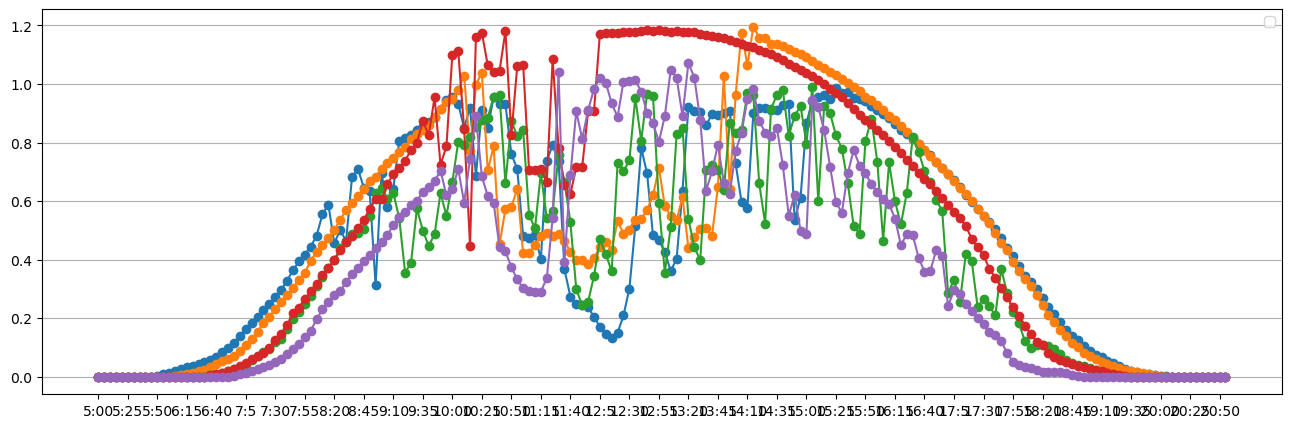

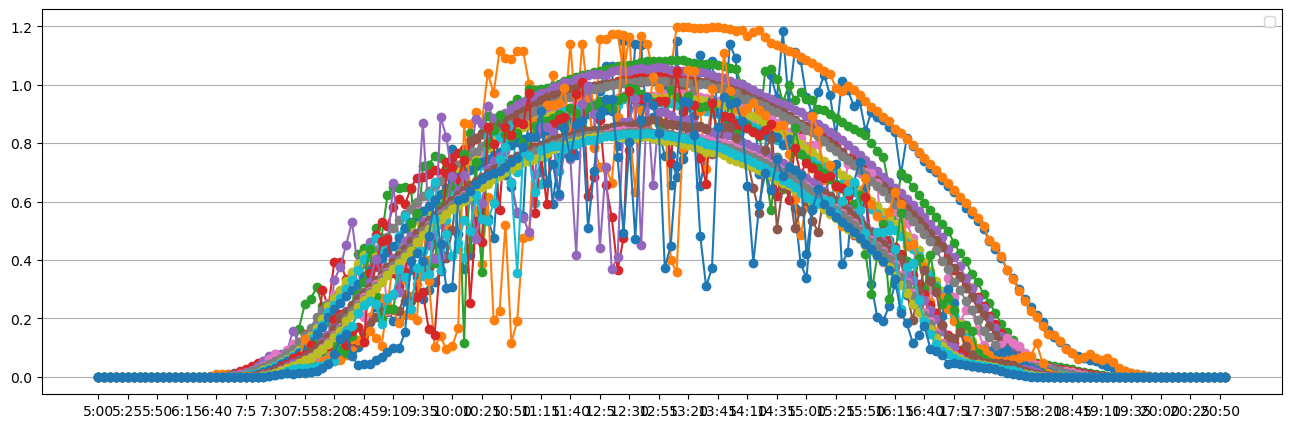

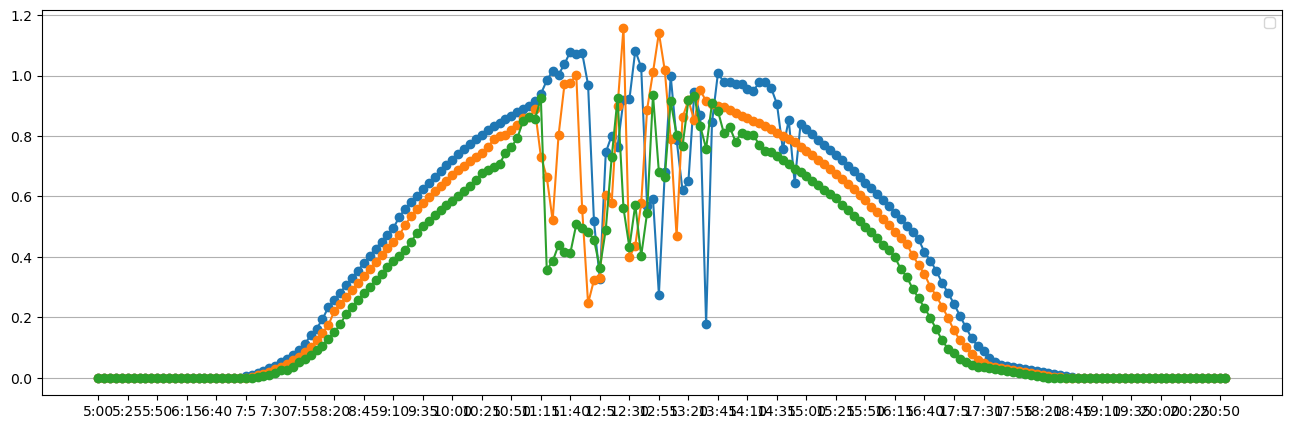

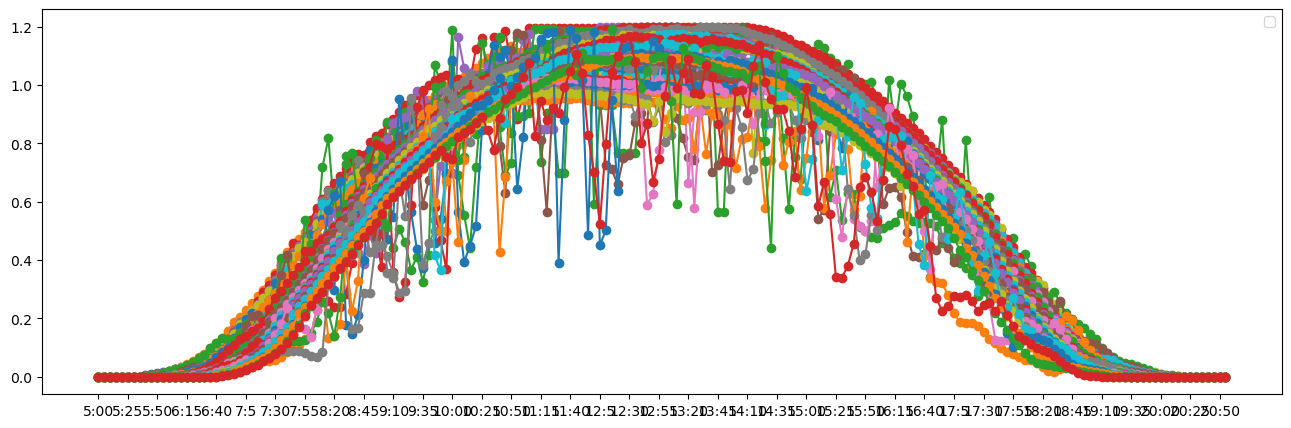

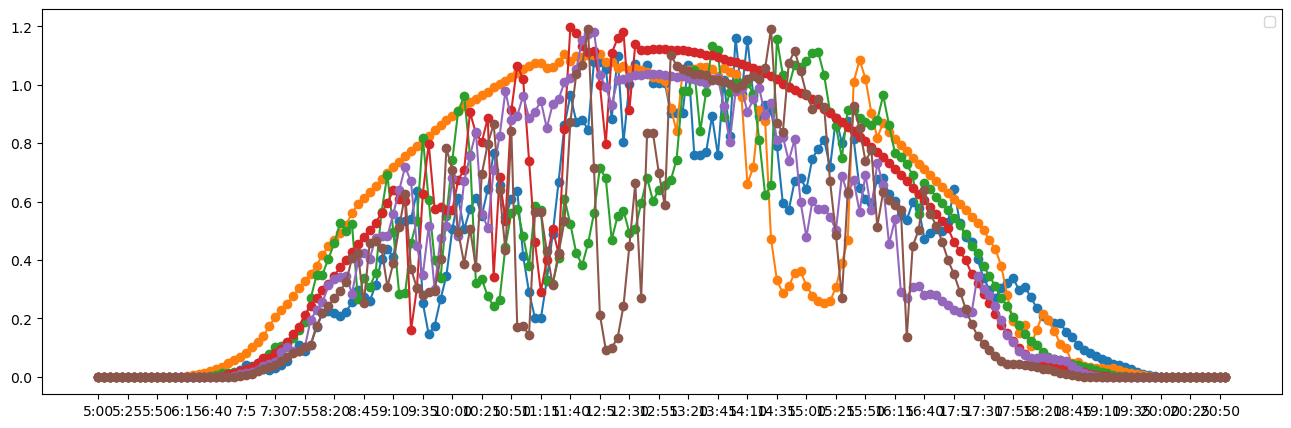

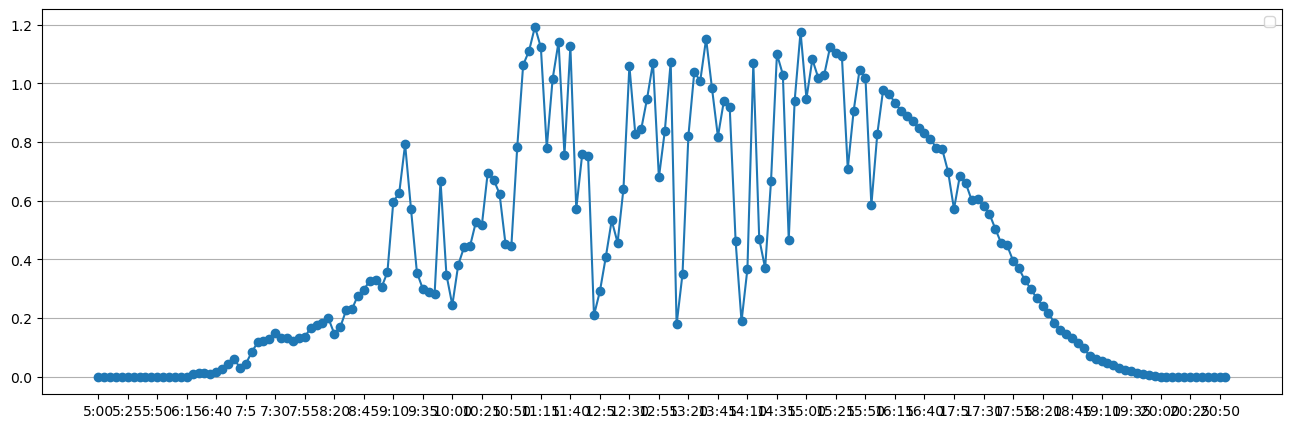

In [120]:
kmeans_results_plot(df=df_normalised_timeseries, cluster_labels=stl_cluster_labels_multi, cluster_num=6)

## 6.3 The Hodrick-Prescott (HP) filter (HPFilter)

In [106]:
def hpfilter_plot(df, trend, cyclical):
    plt.figure(figsize=(12, 6))

    plt.subplot(311)
    plt.plot(df, label='Original')
    plt.legend(loc='best')
    plt.title('Original Time Series')

    plt.subplot(312)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.title('Trend Component')

    plt.subplot(313)
    plt.plot(cyclical, label='Cyclical')
    plt.legend(loc='best')
    plt.title('Cyclical Component')

    plt.tight_layout()
    plt.show()

In [107]:
import statsmodels.api as sm

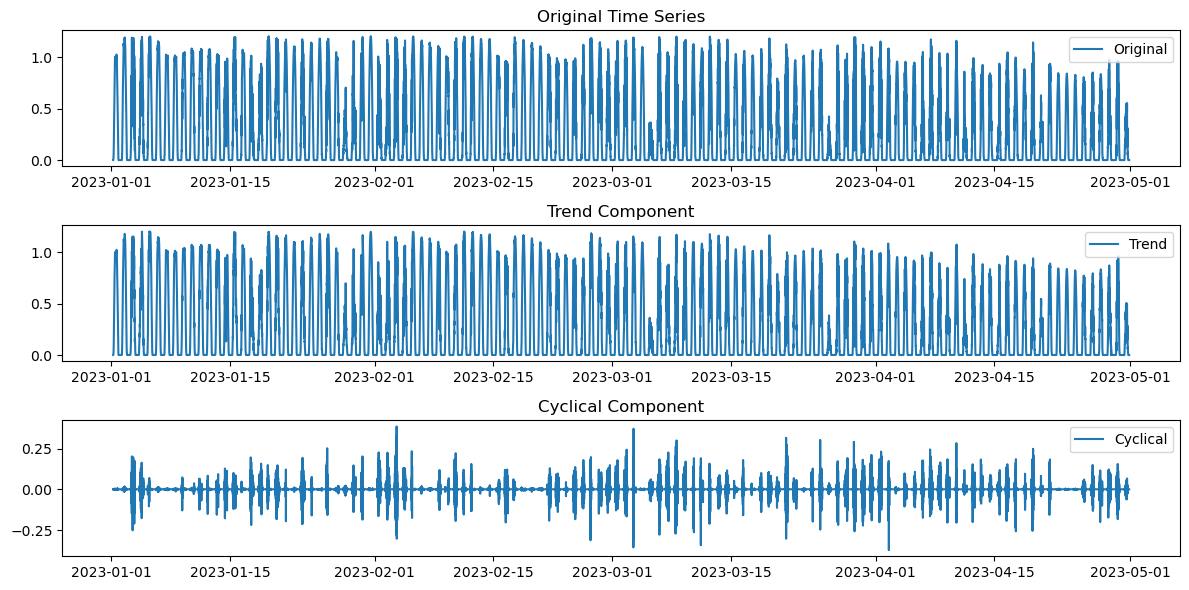

MNTR|7053139  hour        date  trend:MNTR|7053139  \
time                                                                            
2023-01-01 05:00:00+00:00           0.0     5  2023-01-01        3.762107e-06   
2023-01-01 05:05:00+00:00           0.0     5  2023-01-01        6.969310e-06   
2023-01-01 05:10:00+00:00           0.0     5  2023-01-01        2.652297e-06   
2023-01-01 05:15:00+00:00           0.0     5  2023-01-01       -3.065177e-05   
2023-01-01 05:20:00+00:00           0.0     5  2023-01-01       -1.197103e-04   
...                                 ...   ...         ...                 ...   
2023-04-30 20:35:00+00:00           0.0    20  2023-04-30        2.453158e-15   
2023-04-30 20:40:00+00:00           0.0    20  2023-04-30        2.186243e-15   
2023-04-30 20:45:00+00:00           0.0    20  2023-04-30        8.773031e-16   
2023-04-30 20:50:00+00:00           0.0    20  2023-04-30        1.302531e-16   
2023-04-30 20:55:00+00:00           0.0    20  2023-04-30       -2.055990e-16   

                           cyclical:MNTR|7053139  
time                                              
2023-01-01 05:00:00+00:00          -3.762107e-06  
2023-01-01 05:05:00+00:00          -6.969310e-06  
2023-01-01 05:10:00+00:00          -2.652297e-06  
2023-01-01 05:15:00+00:00           3.065177e-05  
2023-01-01 05:20:00+00:00           1.197103e-04  
...                                          ...  
2023-04-30 20:35:00+00:00          -2.453158e-15  
2023-04-30 20:40:00+00:00          -2.186243e-15  
2023-04-30 20:45:00+00:00          -8.773031e-16  
2023-04-30 20:50:00+00:00          -1.302531e-16  
2023-04-30 20:55:00+00:00           2.055990e-16  

[23040 rows x 5 columns]

In [108]:
# # ================================================================
# = decomposition of each monitor at each day with HPFilter
# # ================================================================

df_hpf = df_raw_decom.copy()

cycle, trend = sm.tsa.filters.hpfilter(df_raw_decom[MID], lamb=0.5)
df_hpf['trend:' + MID] = trend.values
df_hpf['cyclical:' + MID] = cycle.values
hpfilter_plot(df=df_raw_decom[MID], trend=trend, cyclical=cycle)

df_hpf

In [109]:
df_normalised_hpf = create_data_forlearning(df=df_hpf, fea_num=2, filter_name='hpf')
df_normalised_hpf.head()

date trend_5:00 trend_5:5 trend_5:10 trend_5:15 trend_5:20  \
0  2023-01-01   0.000004  0.000007   0.000003  -0.000031   -0.00012   
1  2023-01-02   0.000002  0.000005   0.000004  -0.000019  -0.000086   
2  2023-01-03   0.000001  0.000003   0.000005   0.000001  -0.000024   
3  2023-01-05   0.000002  0.000004   0.000006  -0.000007  -0.000056   
4  2023-01-06   0.000001  0.000004   0.000006  -0.000003  -0.000047   

  trend_5:25 trend_5:30 trend_5:35 trend_5:40  ... cycle_20:10 cycle_20:15  \
0   -0.00023  -0.000088   0.001042   0.004066  ...   -0.000623    0.000009   
1  -0.000183  -0.000127   0.000635    0.00291  ...   -0.000451   -0.000071   
2  -0.000091  -0.000169  -0.000045   0.000831  ...   -0.000359    0.000202   
3  -0.000152  -0.000193   0.000227   0.001899  ...    -0.00037   -0.000189   
4  -0.000141  -0.000207   0.000118    0.00161  ...   -0.000343   -0.000153   

  cycle_20:20 cycle_20:25 cycle_20:30 cycle_20:35 cycle_20:40 cycle_20:45  \
0    0.000172    0.000099    0.000029        -0.0   -0.000005   -0.000003   
1    0.000143    0.000096    0.000032    0.000002   -0.000004   -0.000003   
2     0.00018    0.000071    0.000011   -0.000006   -0.000005   -0.000002   
3    0.000146    0.000118    0.000044    0.000006   -0.000004   -0.000003   
4    0.000141    0.000109     0.00004    0.000005   -0.000004   -0.000003   

  cycle_20:50 cycle_20:55  
0   -0.000001   -0.000001  
1   -0.000001        -0.0  
2        -0.0         0.0  
3   -0.000001        -0.0  
4   -0.000001        -0.0  

[5 rows x 385 columns]

## 6.4. Multiple Kmeans with HPFilter

In [110]:
hpf_cluster_labels_multi = kmeans_clustering(df=df_normalised_hpf, cluster_num=10, metric_name='dtw')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

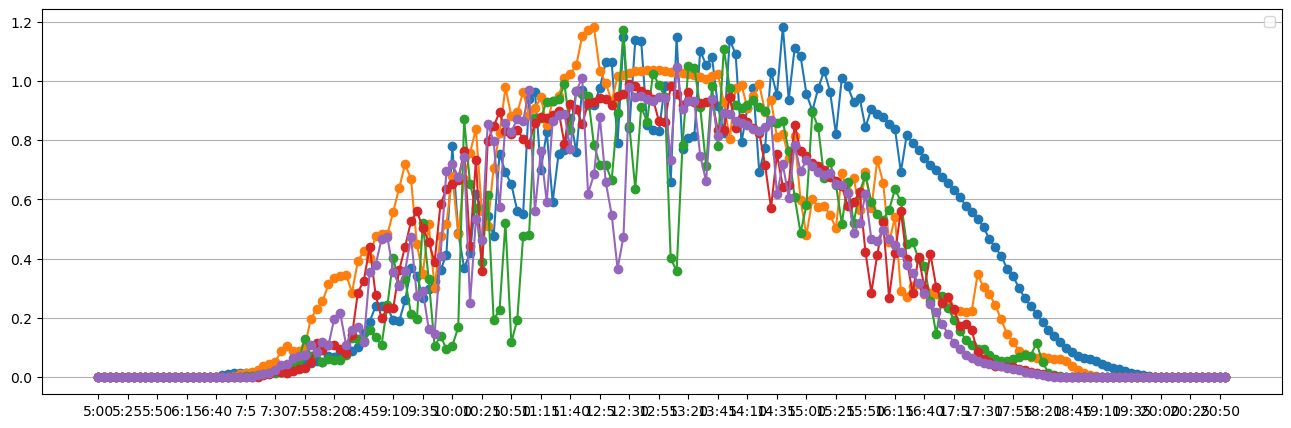

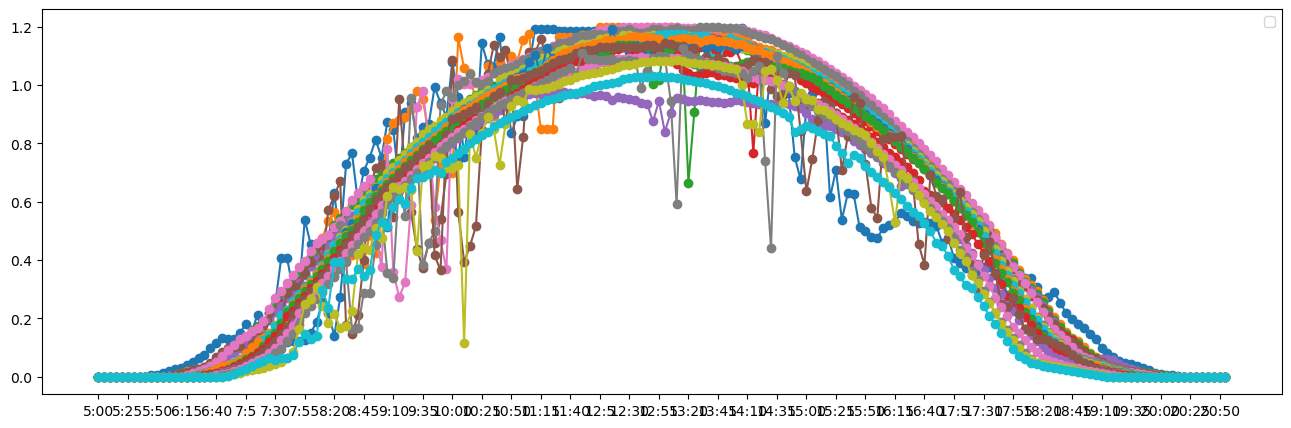

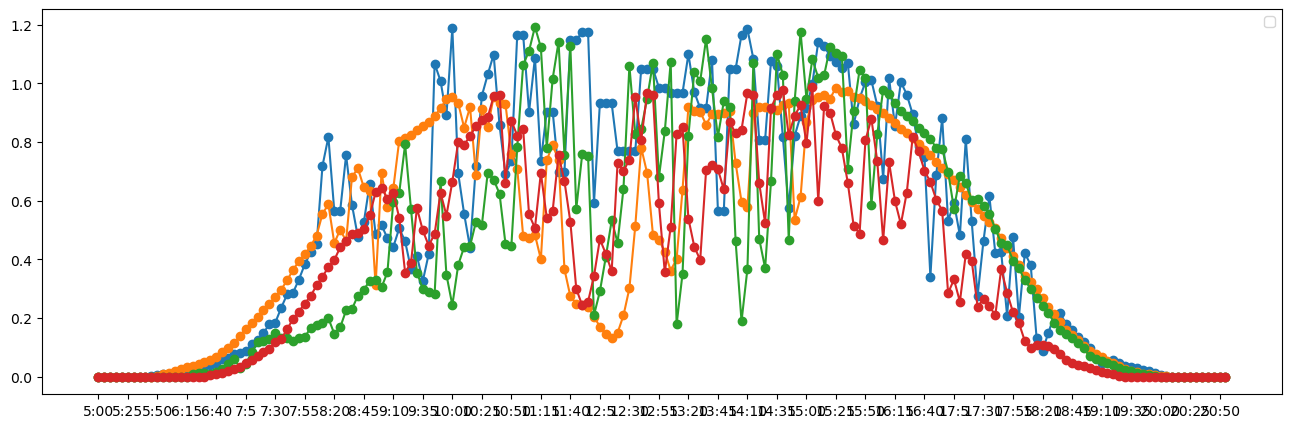

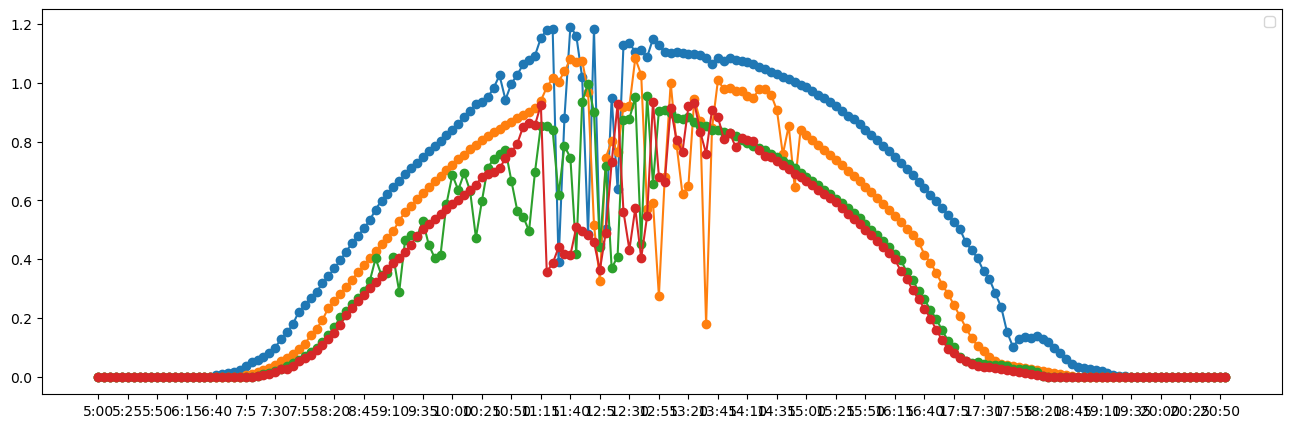

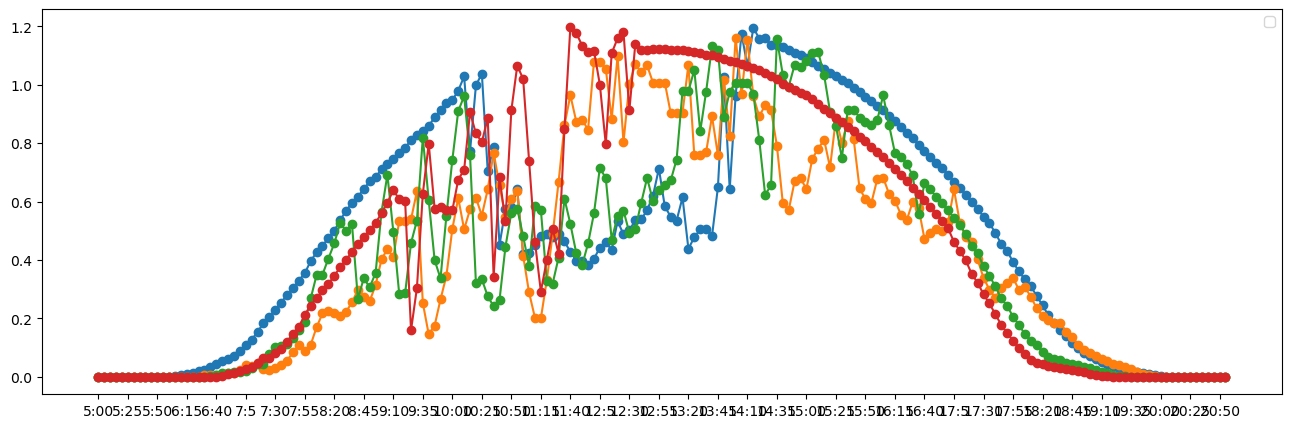

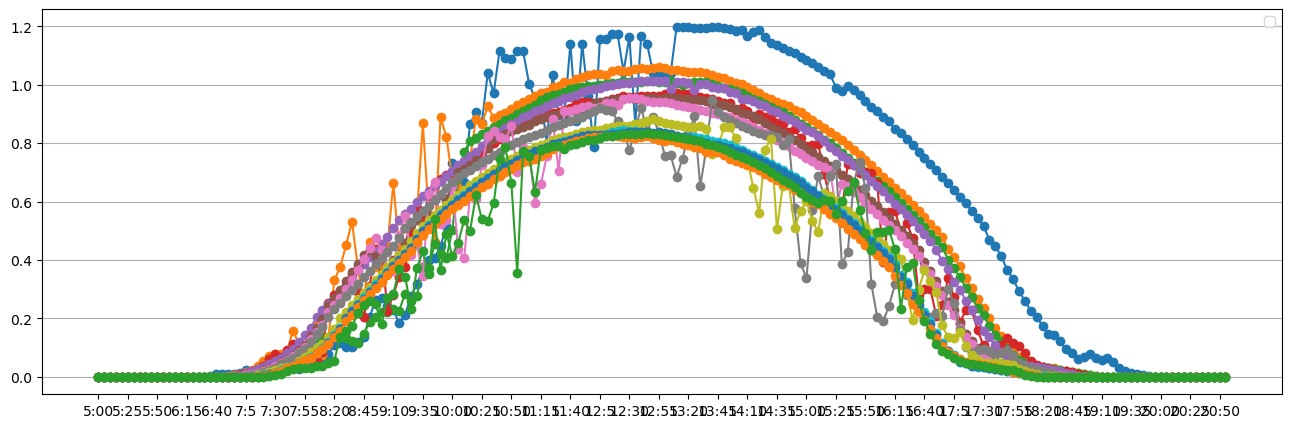

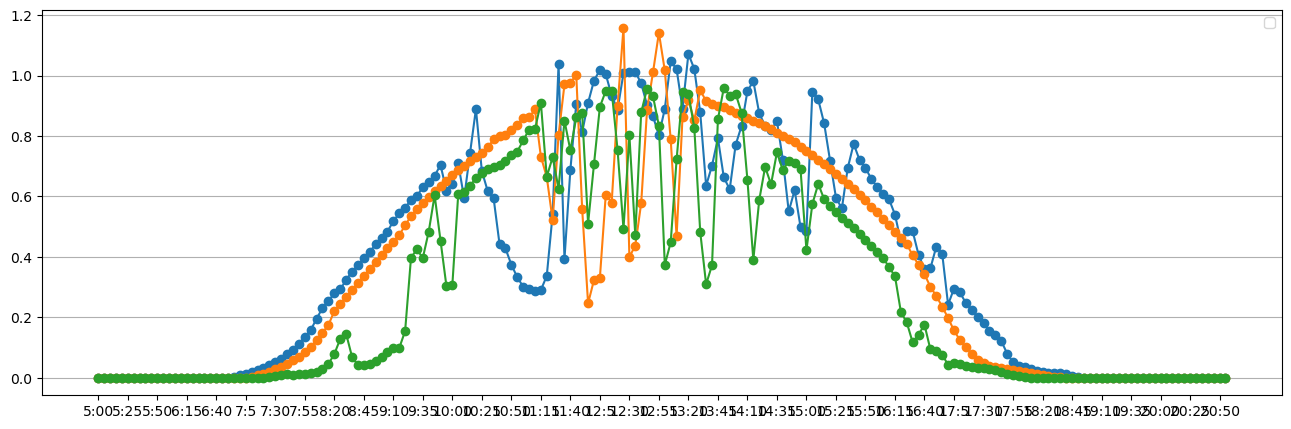

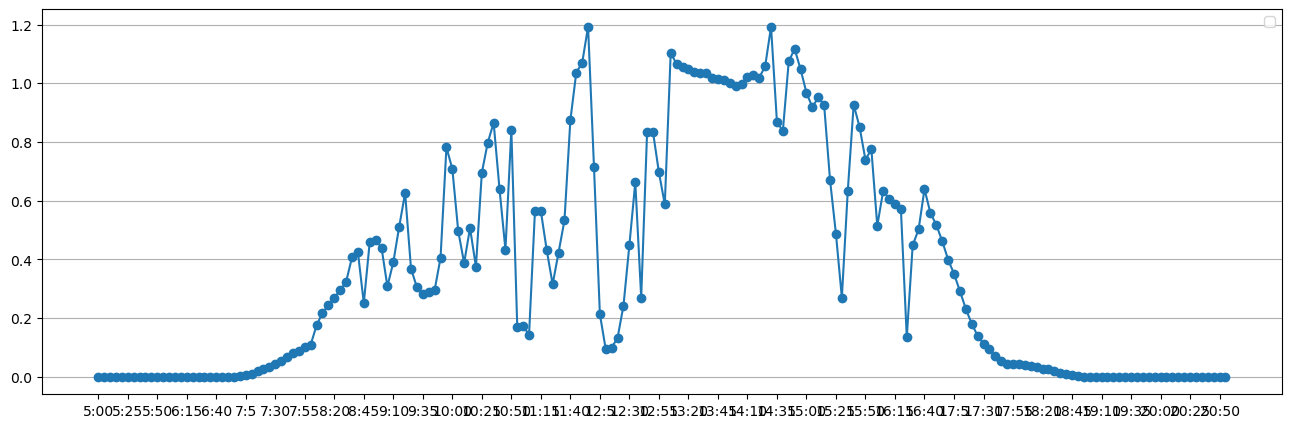

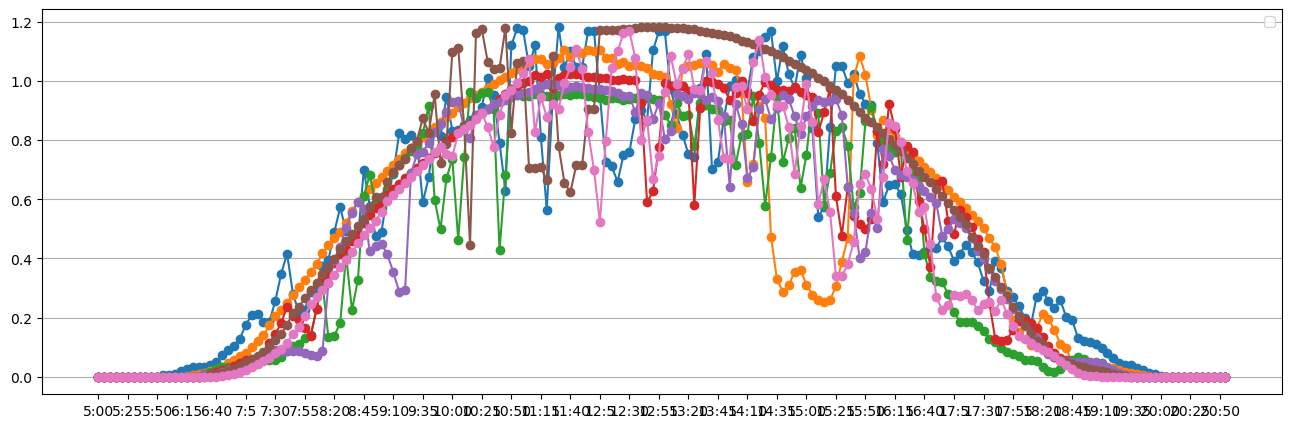

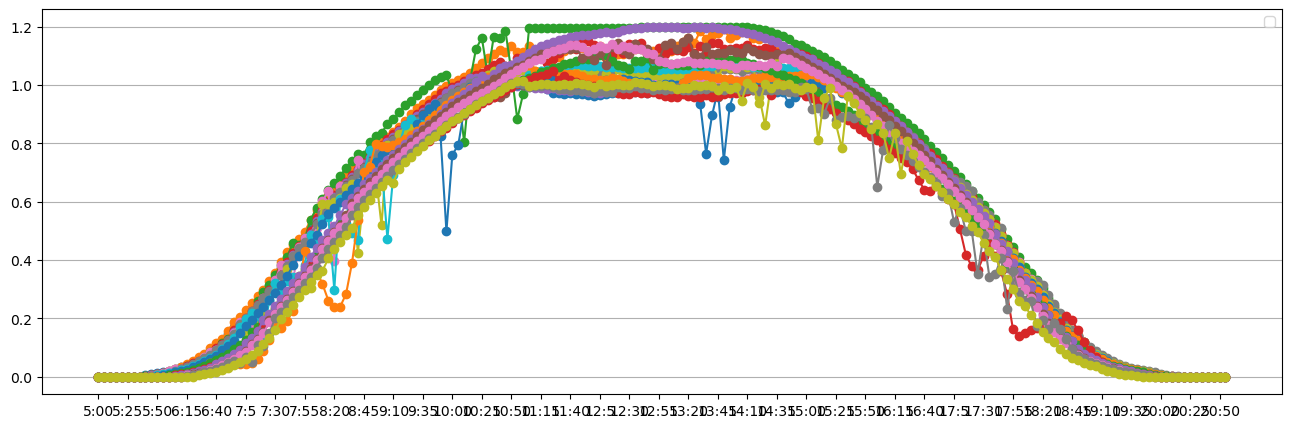

In [123]:
kmeans_results_plot(df=df_normalised_timeseries, cluster_labels=hpf_cluster_labels_multi, cluster_num=10)